# Dogs vs cats:

<img src="img/woof_meow.png" width="100%">

This data contains photos of dogs and cats.
We will use ML (without deep-learning) to try and tackle this problme.

In [1]:
import cv2 as cv
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

Setting some global variable as settings

In [2]:
SIZE = 32
VERBOSE = 0

# Playing with an image!

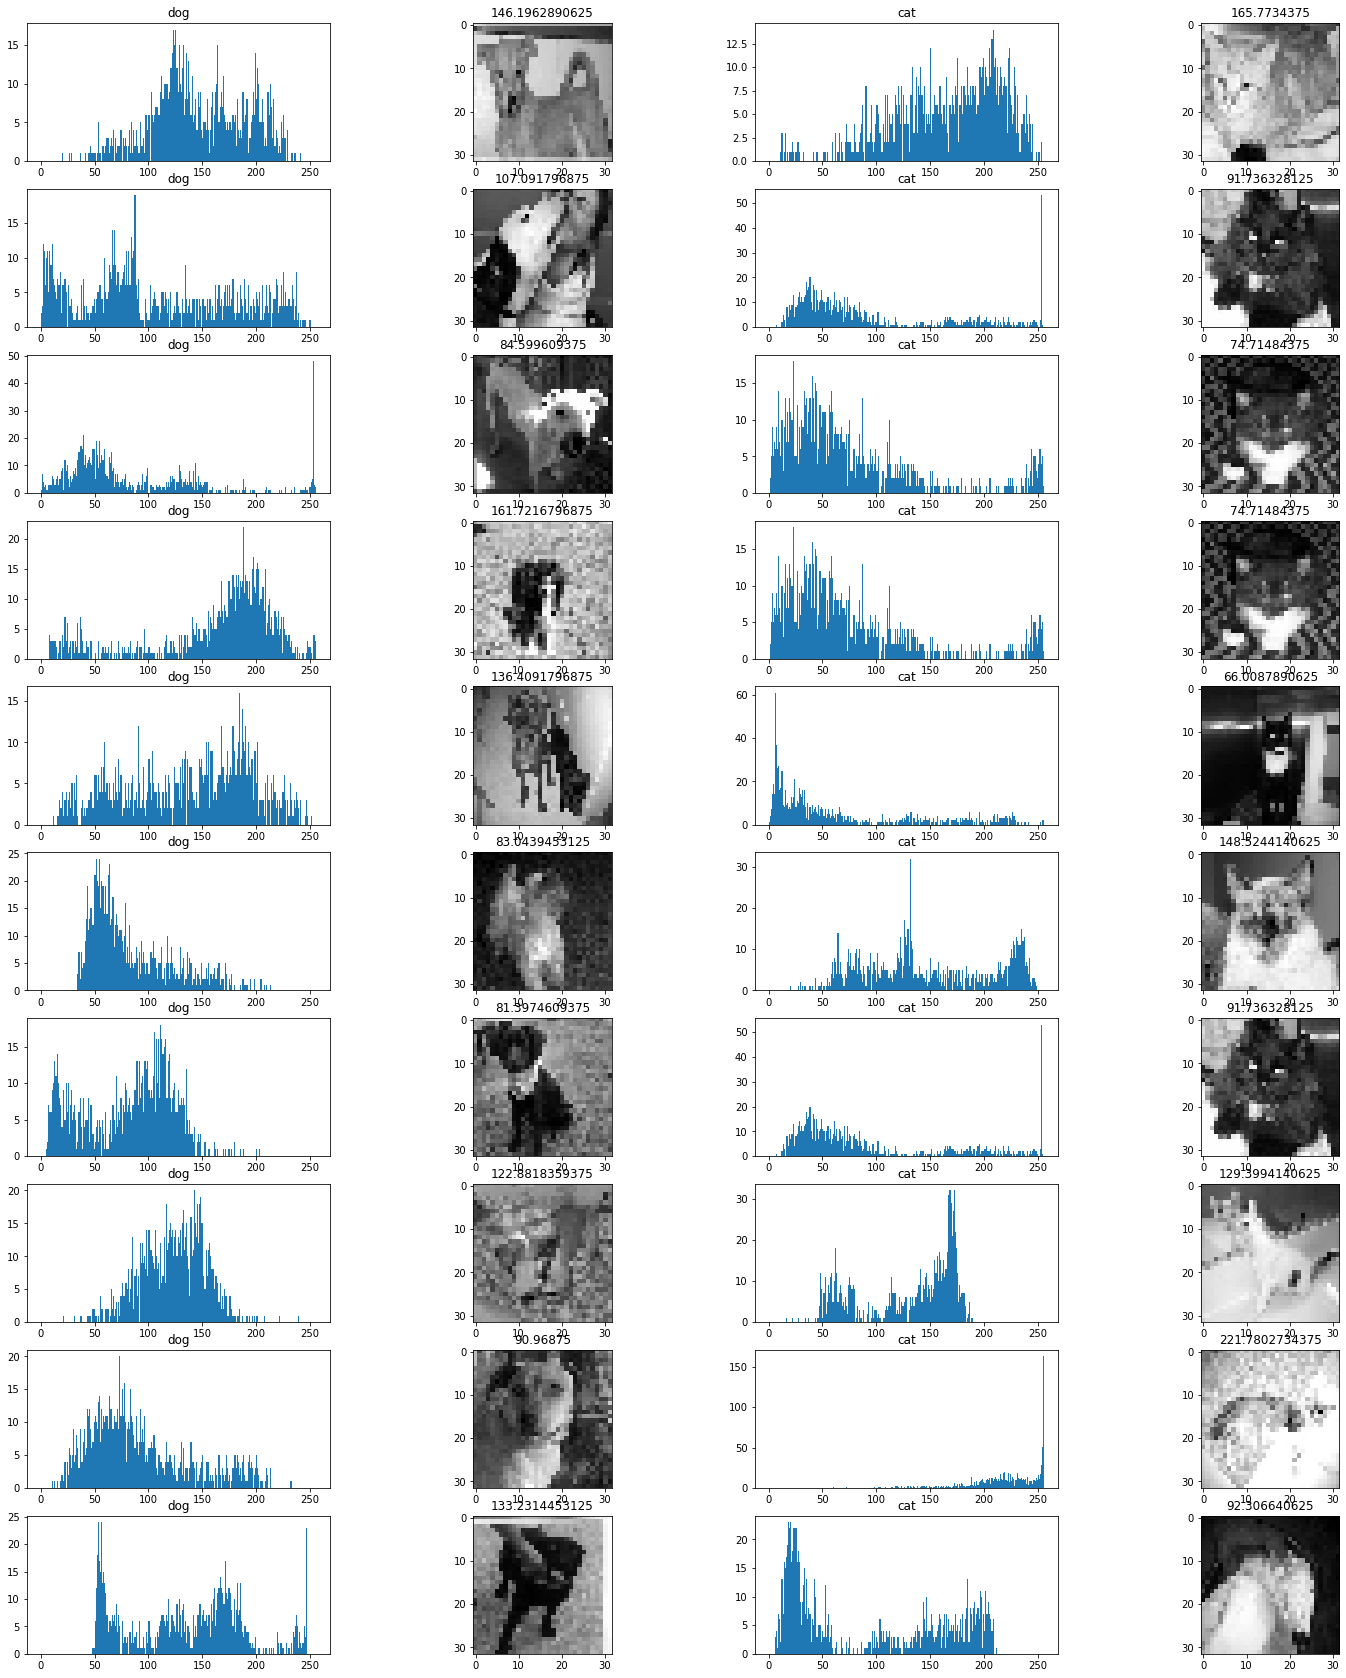

In [3]:
img = cv.imread('data/Cats and dogs/train/dog.10.jpg',0 )
img = cv.resize(img , (SIZE,SIZE))
histr = cv.calcHist([img],[0],None,[256],[0,256])

plt.figure(figsize=(25,30))
i = 1
for x in range(1,40 ,4):
    plt.subplot(10,4,x)
    img = cv.imread('data/Cats and dogs/train/dog.{}.jpg'.format(np.random.randint(1,100)),0 )
    img = cv.resize(img , (SIZE,SIZE))
    plt.hist(img.ravel(),256,[0,256])
    plt.title("dog")

    plt.subplot(10,4,x+ 1)
    plt.title(img.ravel().mean())
    plt.imshow(img,cmap='gray')

    plt.subplot(10,4,x + 2)
    img = cv.imread('data/Cats and dogs/train/cat.{}.jpg'.format(np.random.randint(1,100)),0 )
    img = cv.resize(img , (SIZE,SIZE))
    plt.hist(img.ravel(),256,[0,256])
    plt.title("cat")

    plt.subplot(10,4,x+ 3)
    plt.title(img.ravel().mean())
    plt.imshow(img,cmap='gray')

plt.show()

Wow, even at 32*32(for some photos it just shy of 30% of the data) you can still understand the image, and unfortunately the intensity disterbution does not tell use a lot. So we will have to ignore it.

## Loading the data
So we will loop troghout all the photos and convert them to 32x32 RGB photos.

In [4]:
def procces_image(img_path):
    img = cv.imread(img_path  )
    img = cv.resize(img , (SIZE,SIZE))

    img = img.reshape(SIZE*SIZE*3)
    img = np.append(img,img.ravel().mean())
    return img

In [5]:
def load_data(path):
    x = []
    y = []

    for file in os.listdir(path):
        label = file.split('.')[-3]
        data = procces_image("{}/{}".format(path,file))
        x.append(data)
        y.append(label)
    return x,y

In [6]:
X,Y = load_data('data/Cats and dogs/train')

In [7]:
X = np.asarray(X)
Y = np.asarray(Y)

## Preprossing

next we will split the data 2 times, one for validation, and one for testing(as the original testing data has no labels)

In [8]:
from sklearn.model_selection import train_test_split
x_data,x_test,y_data,y_test = train_test_split(X,Y ,random_state=42)
x_train,x_validate,y_train,y_validate = train_test_split(x_data,y_data ,random_state=42)

### pca:
pca is a dimensionalty reduction algorim, that using linear algebra can "combine" 

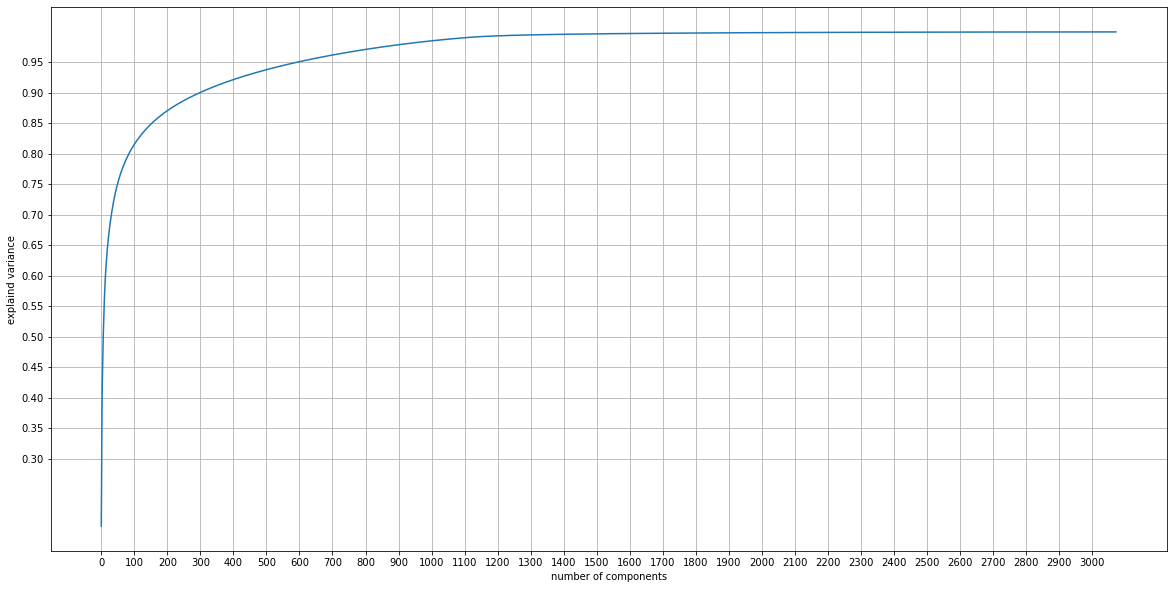

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_[:])

plt.figure(figsize=(20,10))
plt.plot(cumsum)
plt.xlabel("number of components")
plt.ylabel("explaind variance")
plt.grid(True)
plt.xticks(range(0,3100,100))
plt.yticks(np.arange(0.3,1.0,0.05))
plt.show()


So we can see that if we take `n_components=0.95` it will be around 600 components, which is not bad but 400 gives us almost the same variance, so we will go with that.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

preprocess = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.9))],
    verbose=VERBOSE
)

In [11]:
x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

## Machine learning

We are going to use some simple (and some more complex) ML algorithms to try to get the best possible acuraccy.
then using ensambling algorithm we will combine or try to improve our basic algorithms.

In [12]:
x_axis = ["knn","Random \n Forest","Gaussian NB","adaboost","xgboost"]
y_axis = []

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf =  KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

knn_clf.fit(x_reduced,y_train)
score = knn_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("knn:{}".format(score))

knn:0.585537542662116


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=VERBOSE)

rf_clf.fit(x_reduced,y_train)
score = rf_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("rf:{}".format(score))

rf:0.6143344709897611


In [15]:
from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
score = gnb_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("gnb:{}".format(score))

gnb:0.5825511945392492


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=250,learning_rate=0.2)
ada_clf.fit(x_reduced,y_train)
score  = ada_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("ada:{}".format(score))

ada:0.6386518771331058


In [17]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=5000,eta=0.15,max_depth=5,eval_metric='mlogloss')
xgb_clf.fit(x_reduced,y_train)
score = xgb_clf.score(x_validate_reduced,y_validate)
y_axis.append(score)
print("xgb:{}".format(score))

xgb:0.6783276450511946


[0.585537542662116, 0.6143344709897611, 0.5825511945392492, 0.6386518771331058, 0.6783276450511946]


<BarContainer object of 5 artists>

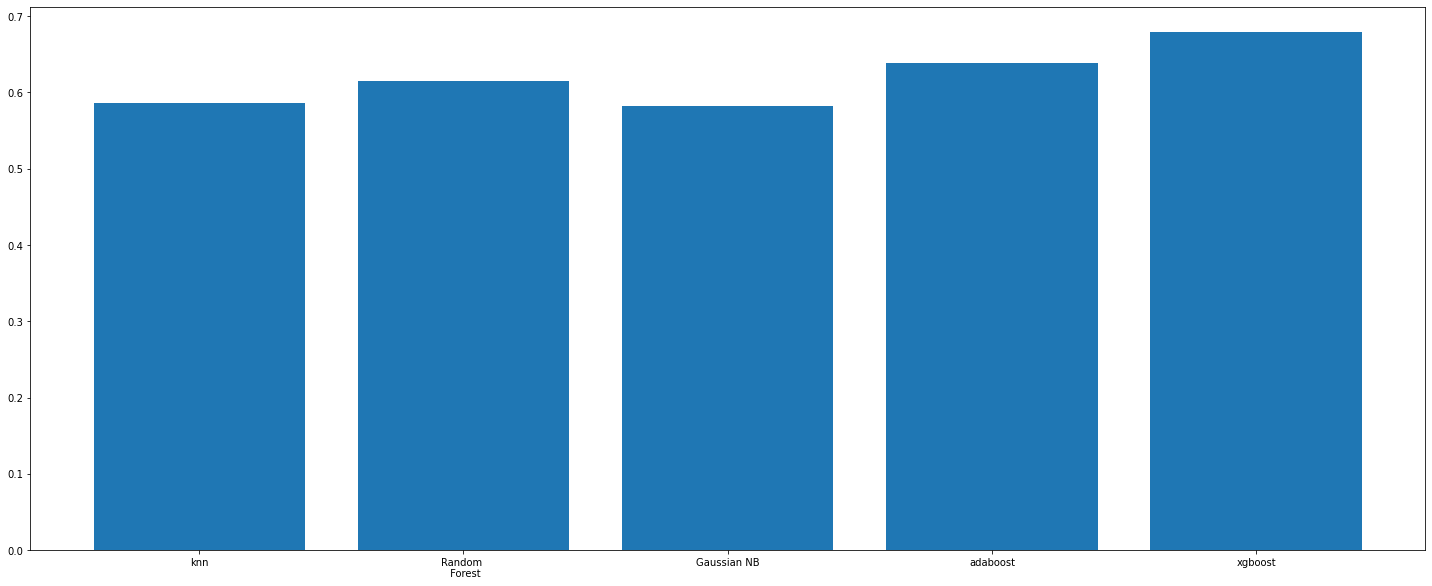

In [18]:
print(y_axis)
plt.figure(figsize=(25,10))
plt.bar(x_axis,y_axis)

### ensambling:

#### the voting algorithm:
works by fitting both of our models and try to vote for right answer.
the soft parameter indicates that the outcome will be based of propability.


In [19]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('ada',ada_clf),    
                ('xgb',xgb_clf)],
            weights=[1,2],
            voting='soft',
            verbose=VERBOSE
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.6787542662116041

#### the stacking classifier:
  the basic idea here is that we make 2 layer of fitting the data:
  1. the first layer contains the `ada boost` and `XGBoost`. we fit the data and the reasult of this will be fed into our second layer.
  2. the second layer consist of the `XGBoost` model, and it will choose our final resualt

In [20]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('ada',ada_clf),    
                ('xgb',xgb_clf),],
                final_estimator=xgb_clf,
                verbose=VERBOSE
)

stacking_clf.fit(x_reduced,y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.6787542662116041

#### the bagging classifier:
  the basic idea here is that we sample the data into mupltiple training sets, train the model few times, and then using hard voting we can get our data.

In [21]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(xgb_clf,n_jobs=-1,verbose=VERBOSE)
bag_clf.fit(x_reduced,y_train)
bag_clf.score(x_validate_reduced,y_validate)

0.679820819112628

## final Test

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

pred = cross_val_predict(bag_clf,x_test,y_test)
cm=confusion_matrix(y_test, pred)

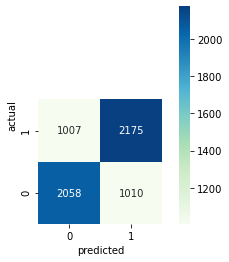

In [23]:
import seaborn as sns

axes=sns.heatmap(cm,square=True,annot=True,fmt='d',cbar=True,cmap=plt.cm.GnBu)
axes.set_xlabel('predicted')
axes.set_ylim(0,3.5)
axes.set_ylabel('actual')

plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         cat       0.67      0.67      0.67      3068
         dog       0.68      0.68      0.68      3182

    accuracy                           0.68      6250
   macro avg       0.68      0.68      0.68      6250
weighted avg       0.68      0.68      0.68      6250



## conclusion


We can see the our fine tuned bagging classifier got a score of 68%,which for an image classifiction without NN is quite good.
